In [1]:
from functools import partial
import logging
import os
import sys
import jax
import haiku as hk
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#import colormaps as cm

from graphcast import rollout
from graphufs.training import construct_wrapped_graphcast
from graphufs.batchloader import BatchLoader
from graphufs.datasets import Dataset
from graphufs.inference import swap_batch_time_dims, store_container

from config import StackedCP0Emulator, StackedCP0Tester

In [33]:
def format_timedelta64_ns(td_ns):
    td_s = td_ns.astype('timedelta64[s]')
    seconds = td_s.astype(int)
    
    days, seconds = divmod(seconds, 86400)
    hours, seconds = divmod(seconds, 3600)
    minutes, seconds = divmod(seconds, 60)

    return f"{days} days, {hours:02d}:{minutes:02d}:{seconds:02d}"

In [34]:
def plot_pred_tar_diff(prediction_array, target_array, projection=ccrs.PlateCarree(), ax=None, 
                       add_coastlines=True, add_borders=False, add_gridlines=True, **kwargs):
    """
    Plots prediction, target and their difference using Cartopy.

    Args:
        prediction_array (xr.DataArray): The xarray DataArray containing prediction.
        target_array (xr.DataArray): The xarray DataArray containing target.
        projection (cartopy.crs.Projection): The map projection to use. Defaults to PlateCarree.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, a new figure and axes are created. Defaults to None.
        add_coastlines (bool, optional): Whether to add coastlines. Defaults to True.
        add_borders (bool, optional): Whether to add country borders. Defaults to False.
        add_gridlines (bool, optional): Whether to add gridlines. Defaults to True.
        **kwargs: Additional keyword arguments to pass to xarray.plot.
    """

    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(30, 5), subplot_kw={'projection': projection})
    else:
        fig = ax.get_figure()

    # calculate mismatch
    diff = prediction_array - target_array
    
    # Plot prediction, target, and diff with Cartopy axes
    prediction_array.plot(ax=ax[0], transform=ccrs.PlateCarree(), **kwargs)
    ax[0].set_title("[P]rediction")
    target_array.plot(ax=ax[1], transform=ccrs.PlateCarree(), **kwargs)
    ax[1].set_title("[T]arget")
    kwargs["vmin"] = None
    kwargs["vmax"] = None
    kwargs["cmap"] = "RdBu_r"
    diff.plot(ax=ax[2], transform=ccrs.PlateCarree(), **kwargs)
    ax[2].set_title("Difference(P-T)")

    for axi in ax.flat:
        if add_coastlines:
            axi.coastlines()
        if add_borders:
            axi.add_feature(cfeature.BORDERS, linestyle='-')
        if add_gridlines:
            agl = axi.gridlines(draw_labels=True, color=None)
            agl.top_labels = False
            agl.right_labels = False
        
    return fig, ax

In [3]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=19,
) -> xr.Dataset:

    params, state = emulator.load_checkpoint_ocn_only(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    inputs, targets, forcings = dataset.get_xarrays(idx)
    inputs.load()
    targets.load()
    forcings.load()

    # retrieve and drop t0
    inittimes = np.atleast_1d(inputs.datetime.isel(time=-2).values)
    inputs = inputs.drop_vars("datetime")
    targets = targets.drop_vars("datetime")
    forcings = forcings.drop_vars("datetime")

    predictions = rollout.chunked_prediction(
        gc,
        rng=jax.random.PRNGKey(0),
        inputs=inputs,
        targets_template=np.nan * targets,
        forcings=forcings,
    )

    for key, mapping in emulator.output_transforms.items():
        with xr.set_options(keep_attrs=True):
            print("Transforming predictions")
            predictions[key] = mapping(predictions[key])
            print("Transforming targets")
            targets[key] = mapping(targets[key])

    # Add t0 as new variable, and swap out for logical sample/batch index
    predictions = swap_batch_time_dims(predictions, inittimes)
    targets = swap_batch_time_dims(targets, inittimes)

    return predictions, targets

In [4]:
stcp0 = StackedCP0Tester()
vds = Dataset(stcp0, mode="validation")

In [5]:
predictions = {}
targets = {}
predictions, targets = predict(emulator=stcp0, dataset=vds, ckpt_id=5)

/global/homes/n/nagarwal/graph-ufs/graphcast/graphcast/rollout.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/global/homes/n/nagarwal/graph-ufs/graphcast/graphcast/autoregressive.py:200: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/global/homes/n/nagarwal/graph-ufs/graphcast/graphcast/autoregressive.py:115: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping

In [6]:
predictions

<xarray.Dataset> Size: 507MB
Dimensions:    (lead_time: 40, time: 1, lat: 192, lon: 384, z_l: 10)
Coordinates:
  * lon        (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat        (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * z_l        (z_l) float64 80B 0.5154 2.765 7.648 15.95 ... 152.1 271.2 417.7
  * lead_time  (lead_time) timedelta64[ns] 320B 0 days 06:00:00 ... 10 days 0...
  * time       (time) datetime64[ns] 8B 2021-12-31T18:00:00
Data variables:
    LW         (lead_time, time, lat, lon) float32 12MB -4.394 -4.464 ... 51.97
    SSH        (lead_time, time, lat, lon) float32 12MB -0.6121 ... 0.07395
    SW         (lead_time, time, lat, lon) float32 12MB 81.45 82.3 ... 140.3
    so         (lead_time, time, z_l, lat, lon) float32 118MB 31.21 ... 0.01153
    temp       (lead_time, time, z_l, lat, lon) float32 118MB -1.684 ... -0.1694
    uo         (lead_time, time, z_l, lat, lon) float32 118MB -0.04355 ... -0...
    vo         (lead_time, time, z_l, lat, lon) float32 118MB -0.001731 ... -...

## Surface Pressure

In [9]:
varname = "pressfc"
long_name = "Surface Pressure"
units = "hPa"
ilead = 10
itime = 0

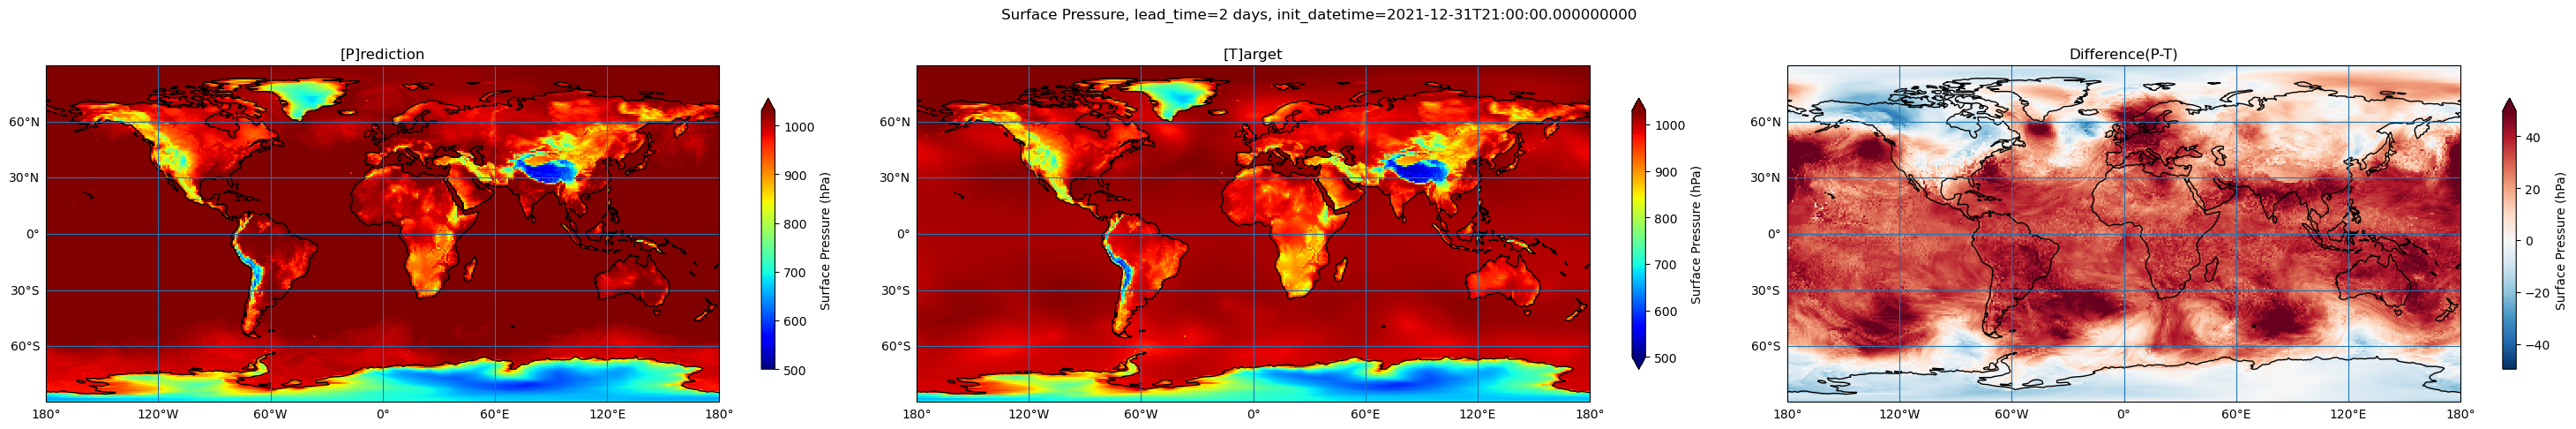

In [10]:
# plot
vmin, vmax = 500, 1030
leadtime = format_timedelta64_ns(predictions.lead_time[ilead].values)
inittime = predictions.time[itime].values
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} ({units})", "pad":0.05}, 
                   "robust":True, "cmap":"jet", "vmin":vmin, "vmax":vmax,}

fig, ax = plot_pred_tar_diff(predictions[varname].isel(time=itime, lead_time=ilead)/100,  # in hPa
                             targets[varname].isel(time=itime, lead_time=ilead)/100, # in hPa
                             **kwargs)

title = f"{long_name}, lead_time={leadtime}, init_datetime={inittime}"
plt.suptitle(title)
plt.tight_layout()

figname = f"{varname}_prediction_target_diff_stacked_cp0.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

## 2m Specific Humidity

In [11]:
varname = "spfh2m"
long_name = "2m Specific Humidity"
units = "kg/kg"
ilead = 10
itime = 0

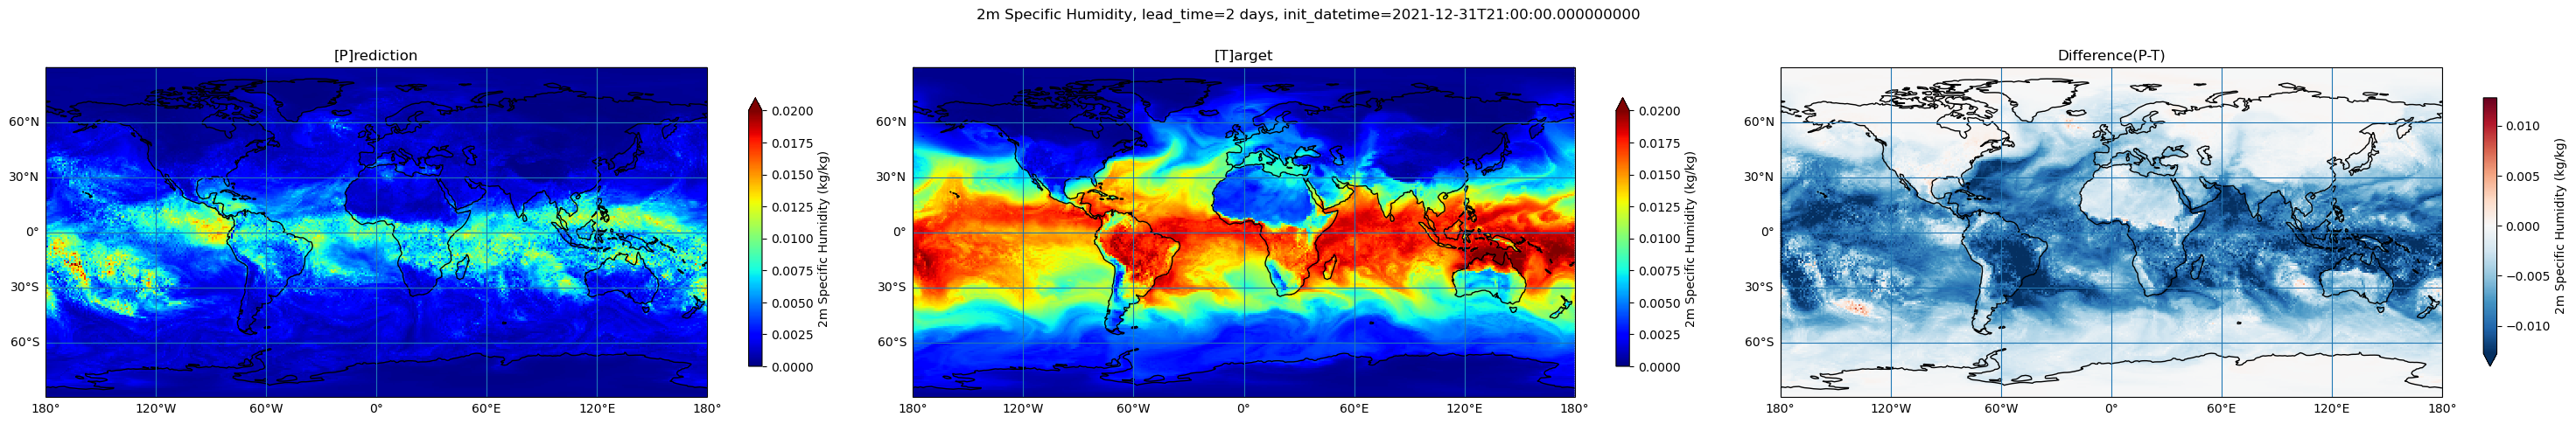

In [12]:
# plot
vmin, vmax = 0, 0.02
leadtime = format_timedelta64_ns(predictions.lead_time[ilead].values)
inittime = predictions.time[itime].values
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} ({units})", "pad":0.05}, 
          "robust":True, "cmap":"jet", "vmin":vmin, "vmax":vmax,}

fig, ax = plot_pred_tar_diff(predictions[varname].isel(time=itime, lead_time=ilead),
                             targets[varname].isel(time=itime, lead_time=ilead), 
                             **kwargs)

title = f"{long_name}, lead_time={leadtime}, init_datetime={inittime}"
plt.suptitle(title)
plt.tight_layout()

figname = f"{varname}_prediction_target_diff_stacked_cp0.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

### 3D Specific Humidity

In [13]:
varname = "spfh"
ilevel = 1
long_name = "Specific Humidity"
units = "kg/kg"
ilead = 0
itime = 0

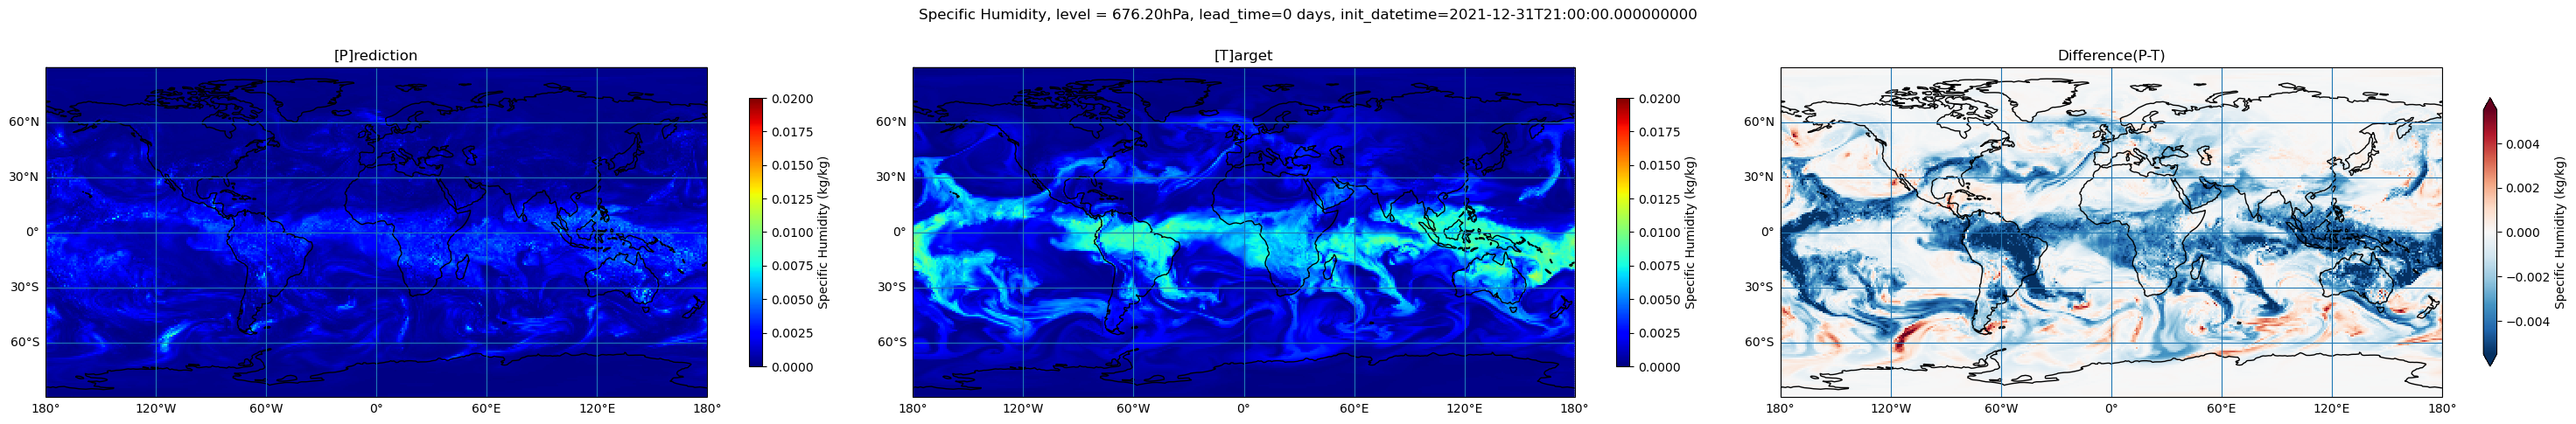

In [14]:
# plot
vmin, vmax = 0, 0.02
leadtime = format_timedelta64_ns(predictions.lead_time[ilead].values)
inittime = predictions.time[itime].values
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} ({units})", "pad":0.05}, 
          "robust":True, "cmap":"jet", "vmin":vmin, "vmax":vmax,}

fig, ax = plot_pred_tar_diff(predictions[varname].isel(time=itime, lead_time=ilead, level=ilevel),
                             targets[varname].isel(time=itime, lead_time=ilead, level=ilevel), 
                             **kwargs)

title = f"{long_name}, level = {predictions.level[ilevel].values:.2f}hPa, lead_time={leadtime}, init_datetime={inittime}"
plt.suptitle(title)
plt.tight_layout()

figname = f"{varname}_prediction_target_diff_stacked_cp0.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

## SSH

In [25]:
varname = "SSH"
long_name = "Sea Surface Height"
units = "m"
ilead = -1
itime = 0

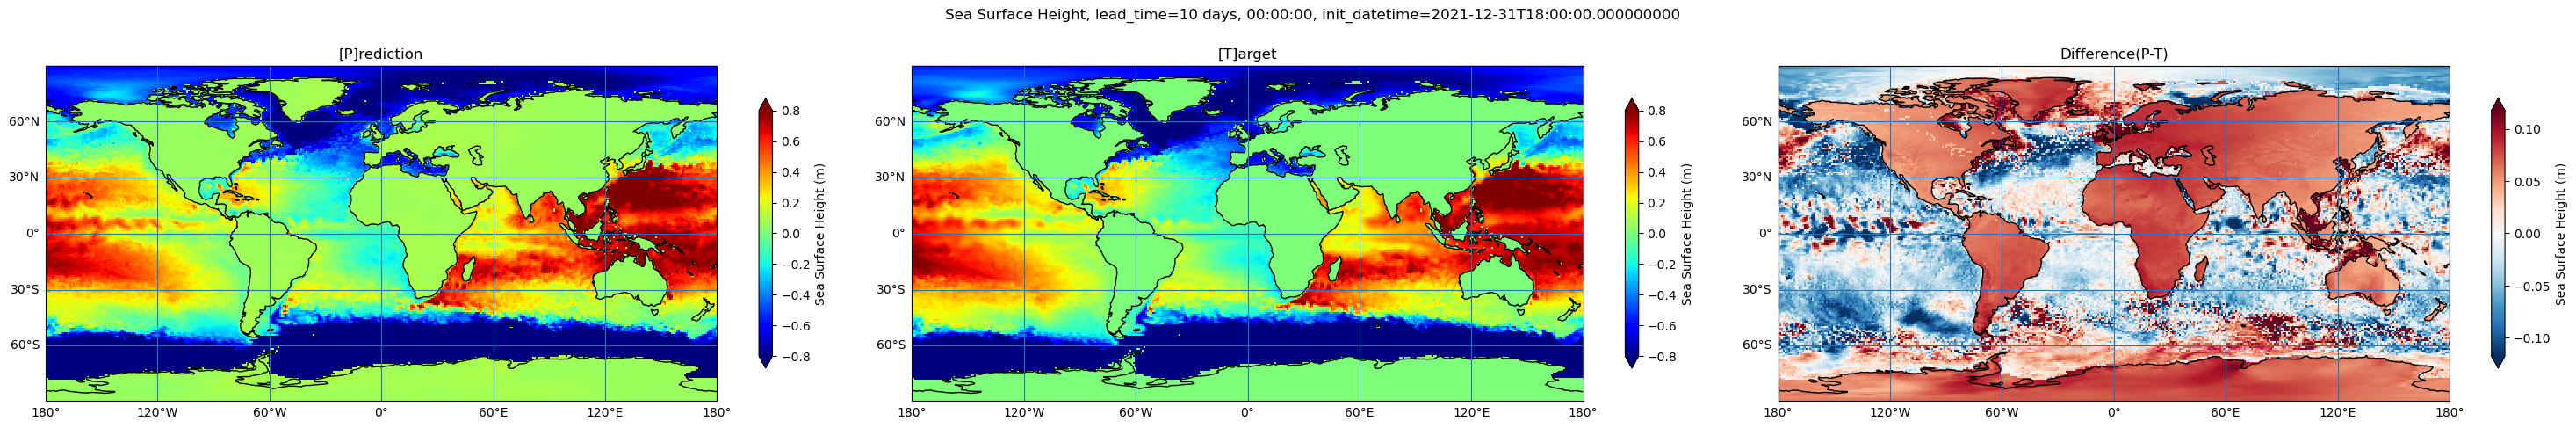

In [35]:
# plot
vmin, vmax = -0.8, 0.8

leadtime = format_timedelta64_ns(predictions.lead_time[ilead].values)
inittime = predictions.time[itime].values
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} ({units})", "pad":0.05}, 
                   "robust":True, "cmap":"jet", "vmin":vmin, "vmax":vmax,}

fig, ax = plot_pred_tar_diff(predictions[varname].isel(time=itime, lead_time=ilead),
                             targets[varname].isel(time=itime, lead_time=ilead),
                             **kwargs)

title = f"{long_name}, lead_time={leadtime}, init_datetime={inittime}"
plt.suptitle(title)
plt.tight_layout()

figname = f"{varname}_prediction_target_diff_stacked_cp0.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

## Temperature

In [41]:
varname = "temp"
iz_l = 1
long_name = "Temperature"
units = "degC"
ilead = -1
itime = 0

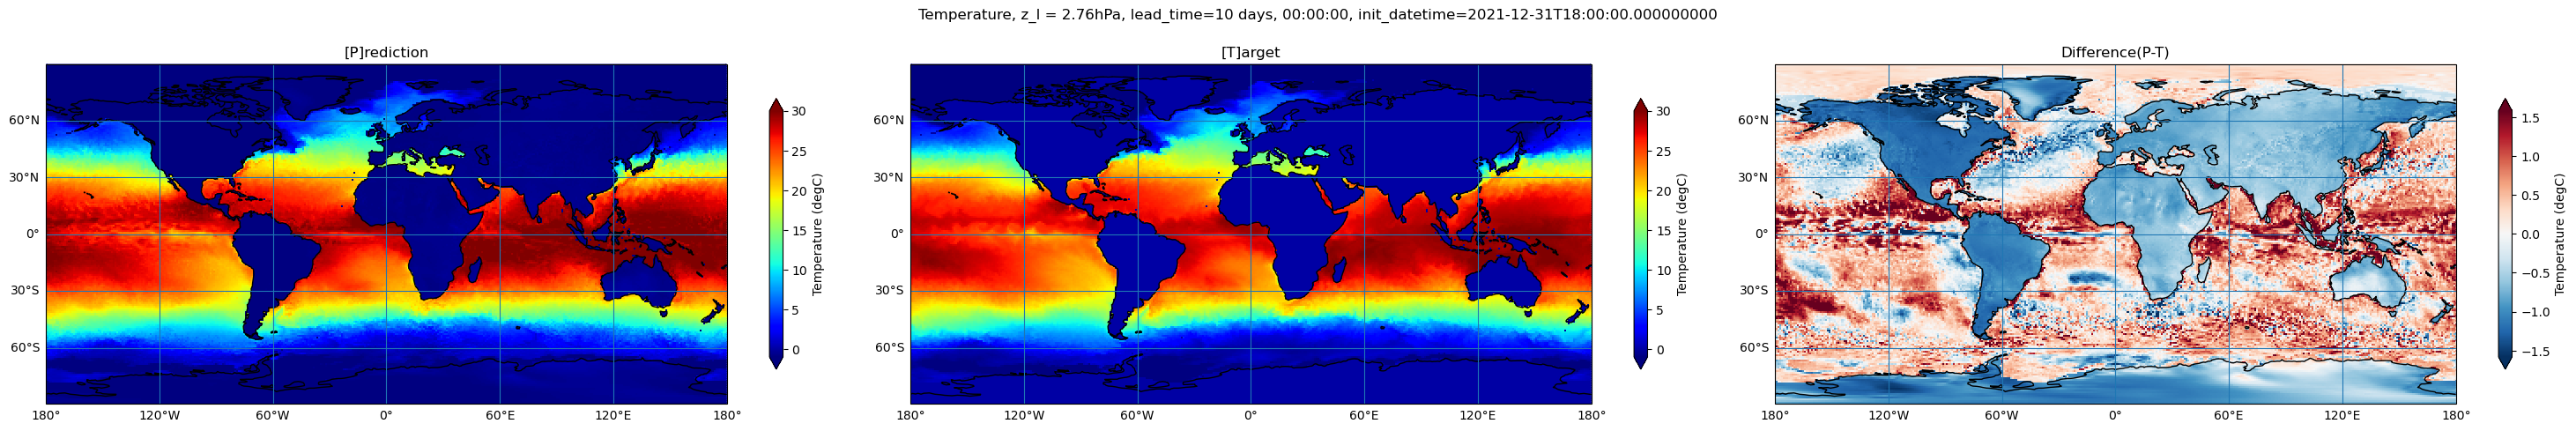

In [42]:
# plot
vmin, vmax = -1, 30
leadtime = format_timedelta64_ns(predictions.lead_time[ilead].values)
inittime = predictions.time[itime].values
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} ({units})", "pad":0.05}, 
          "robust":True, "cmap":"jet", "vmin":vmin, "vmax":vmax,}

fig, ax = plot_pred_tar_diff(predictions[varname].isel(time=itime, lead_time=ilead, z_l=iz_l),
                             targets[varname].isel(time=itime, lead_time=ilead, z_l=iz_l), 
                             **kwargs)

title = f"{long_name}, z_l = {predictions.z_l[iz_l].values:.2f}hPa, lead_time={leadtime}, init_datetime={inittime}"
plt.suptitle(title)
plt.tight_layout()

figname = f"{varname}_prediction_target_diff_stacked_cp0.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

## Sea Ice

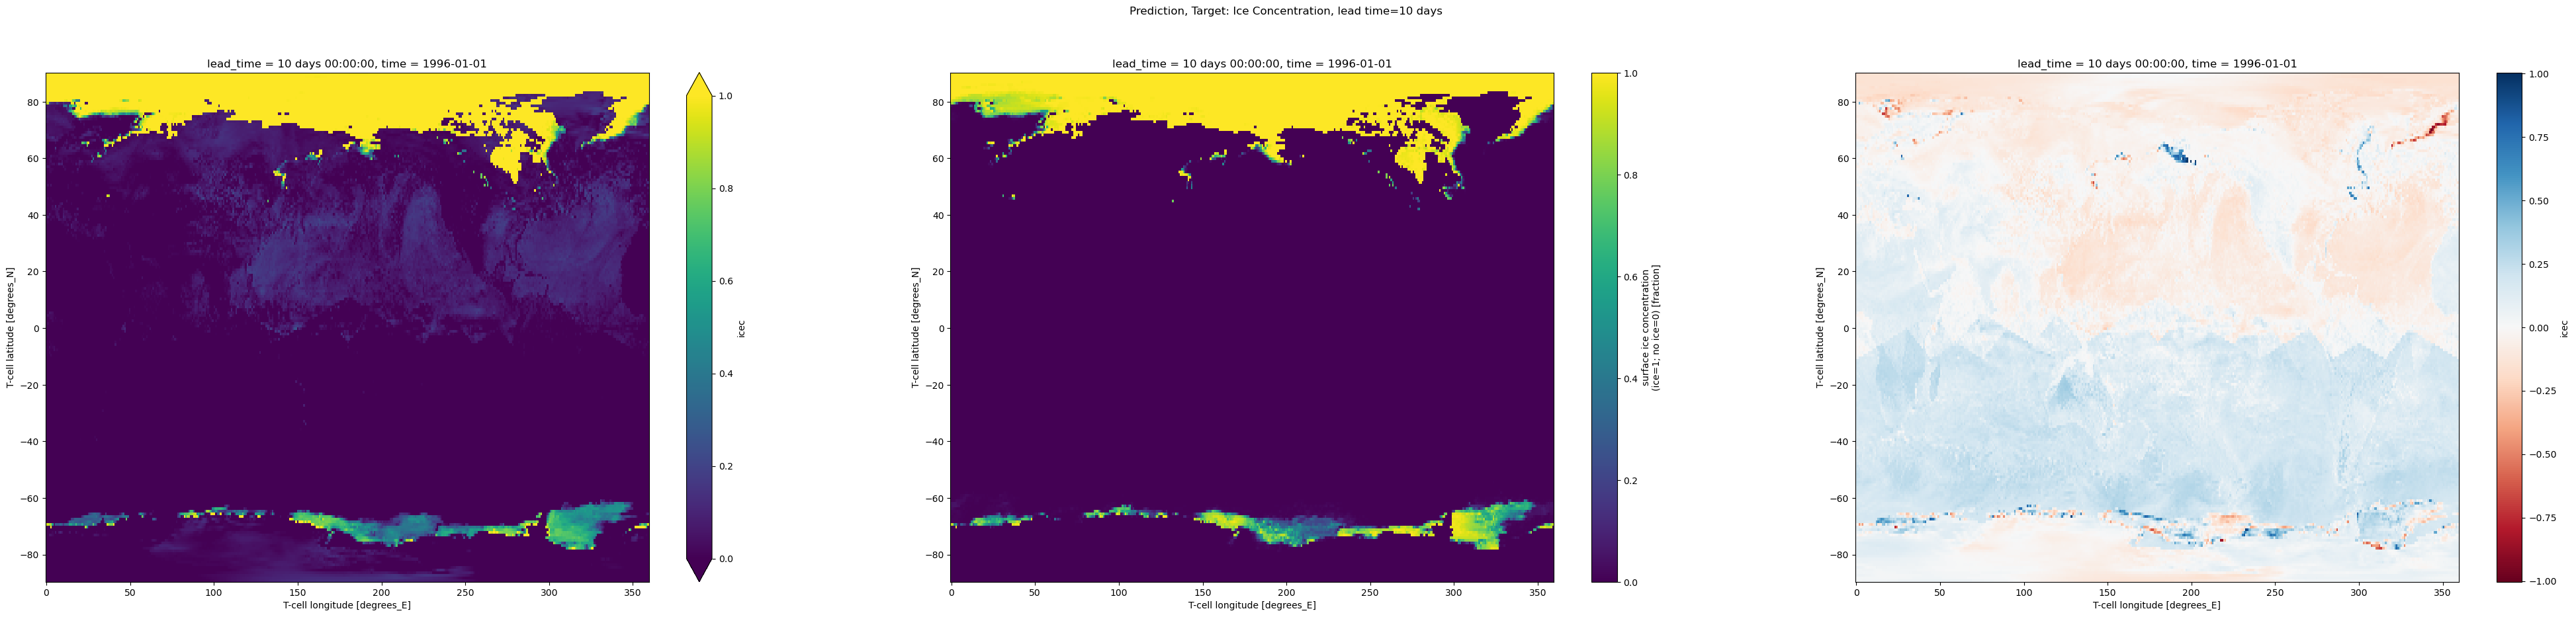

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.icec.isel(time=0, lead_time=-1).plot(ax=ax[0], vmin=0, vmax=1, cmap="viridis")
targets.icec.isel(time=0, lead_time=-1).plot(ax=ax[1])
diff = targets.icec.isel(time=0, lead_time=-1) - predictions.icec.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Ice Concentration, lead time={lead_time_days}')
plt.show()

## Soil Moisture

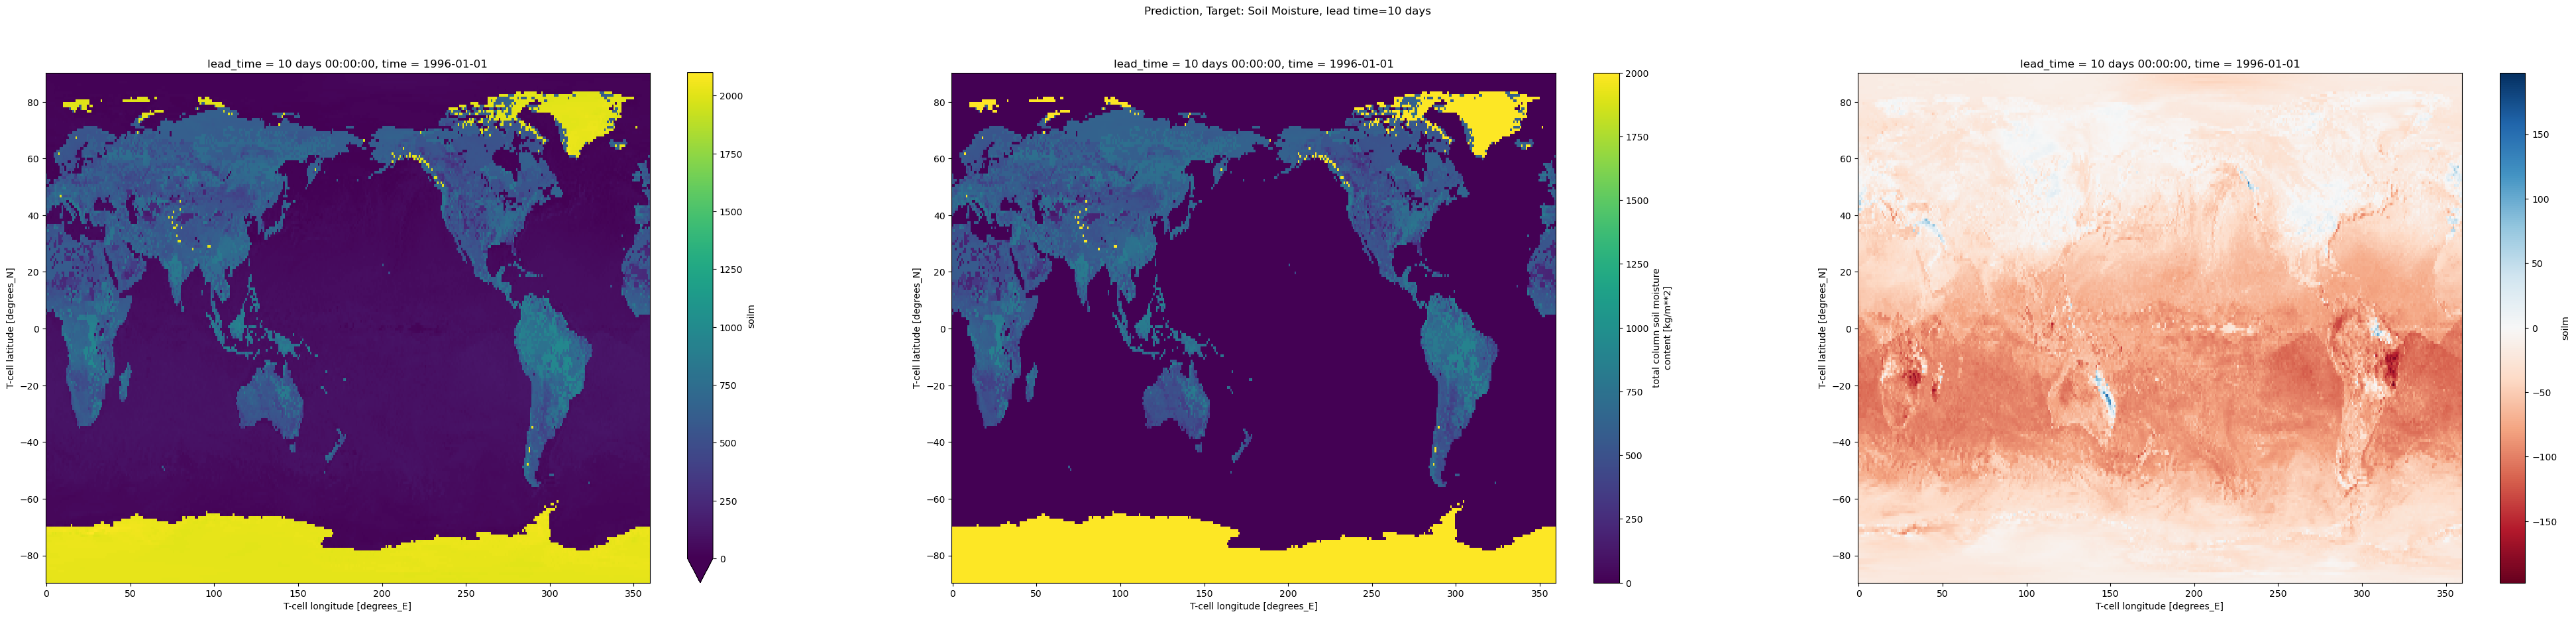

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.soilm.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="viridis", vmin=0)
targets.soilm.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="viridis")
diff = targets.soilm.isel(time=0, lead_time=-1) - predictions.soilm.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Soil Moisture, lead time={lead_time_days}')
plt.show()

## Skin Temperature

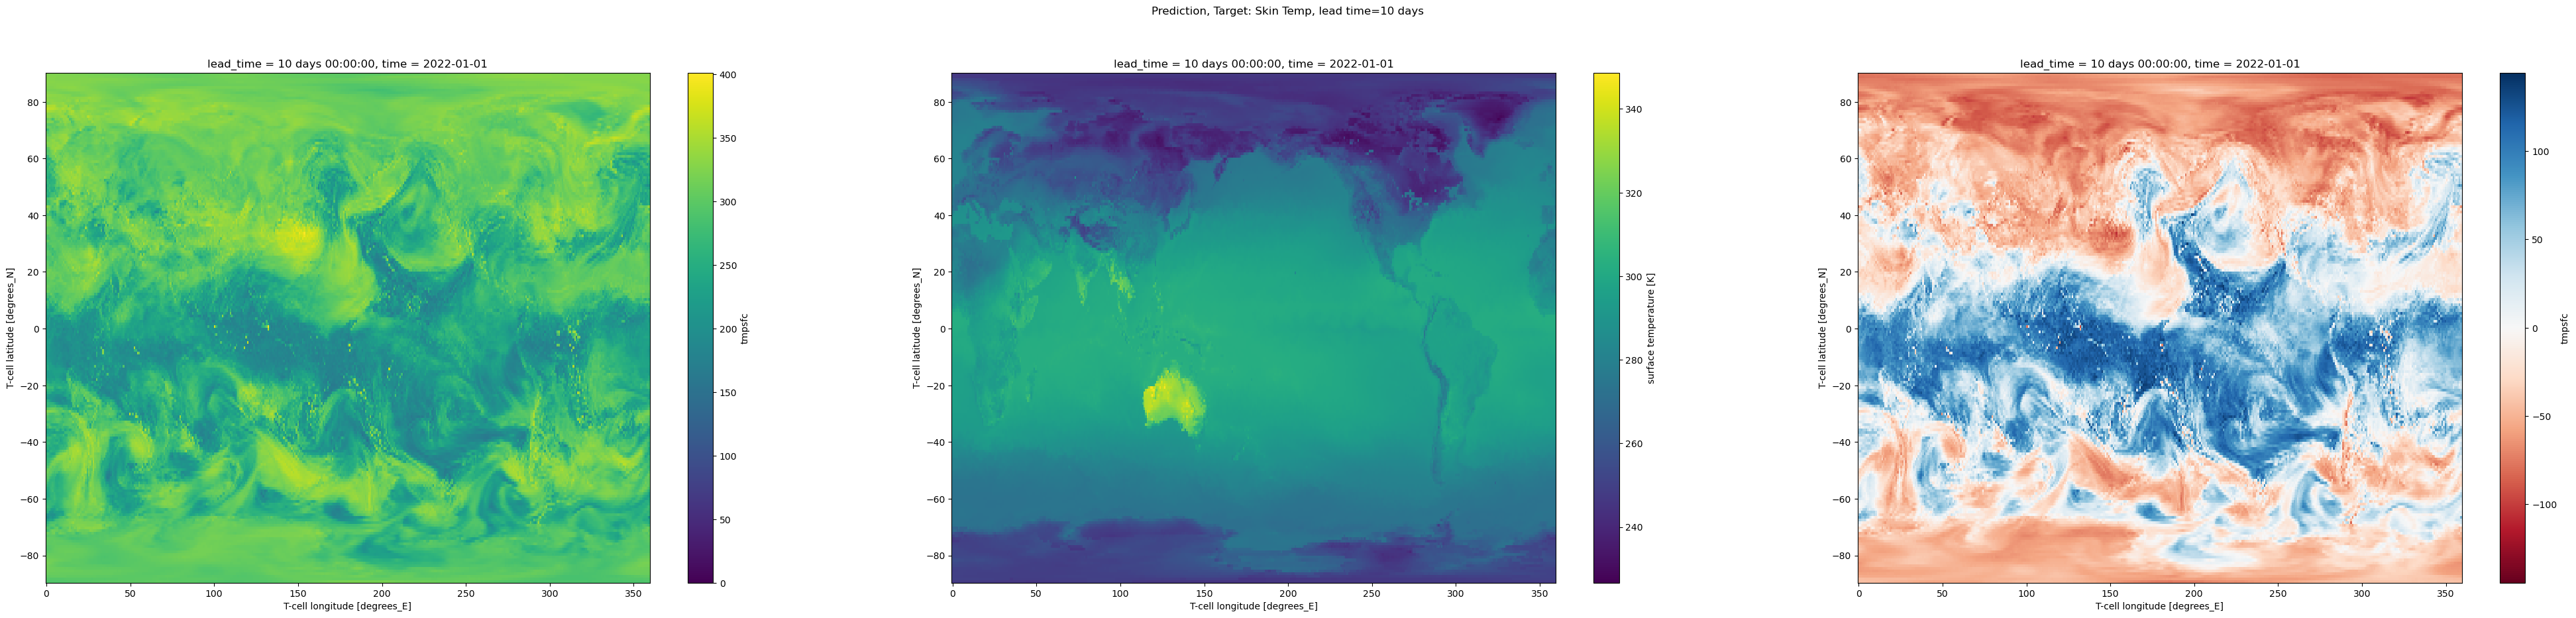

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.tmpsfc.isel(time=0, lead_time=-1).plot(ax=ax[0], cmap="viridis", vmin=0)
targets.tmpsfc.isel(time=0, lead_time=-1).plot(ax=ax[1], cmap="viridis")
diff = targets.tmpsfc.isel(time=0, lead_time=-1) - predictions.tmpsfc.isel(time=0, lead_time=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: Skin Temp, lead time={lead_time_days}')
plt.show()

## 3D ocean

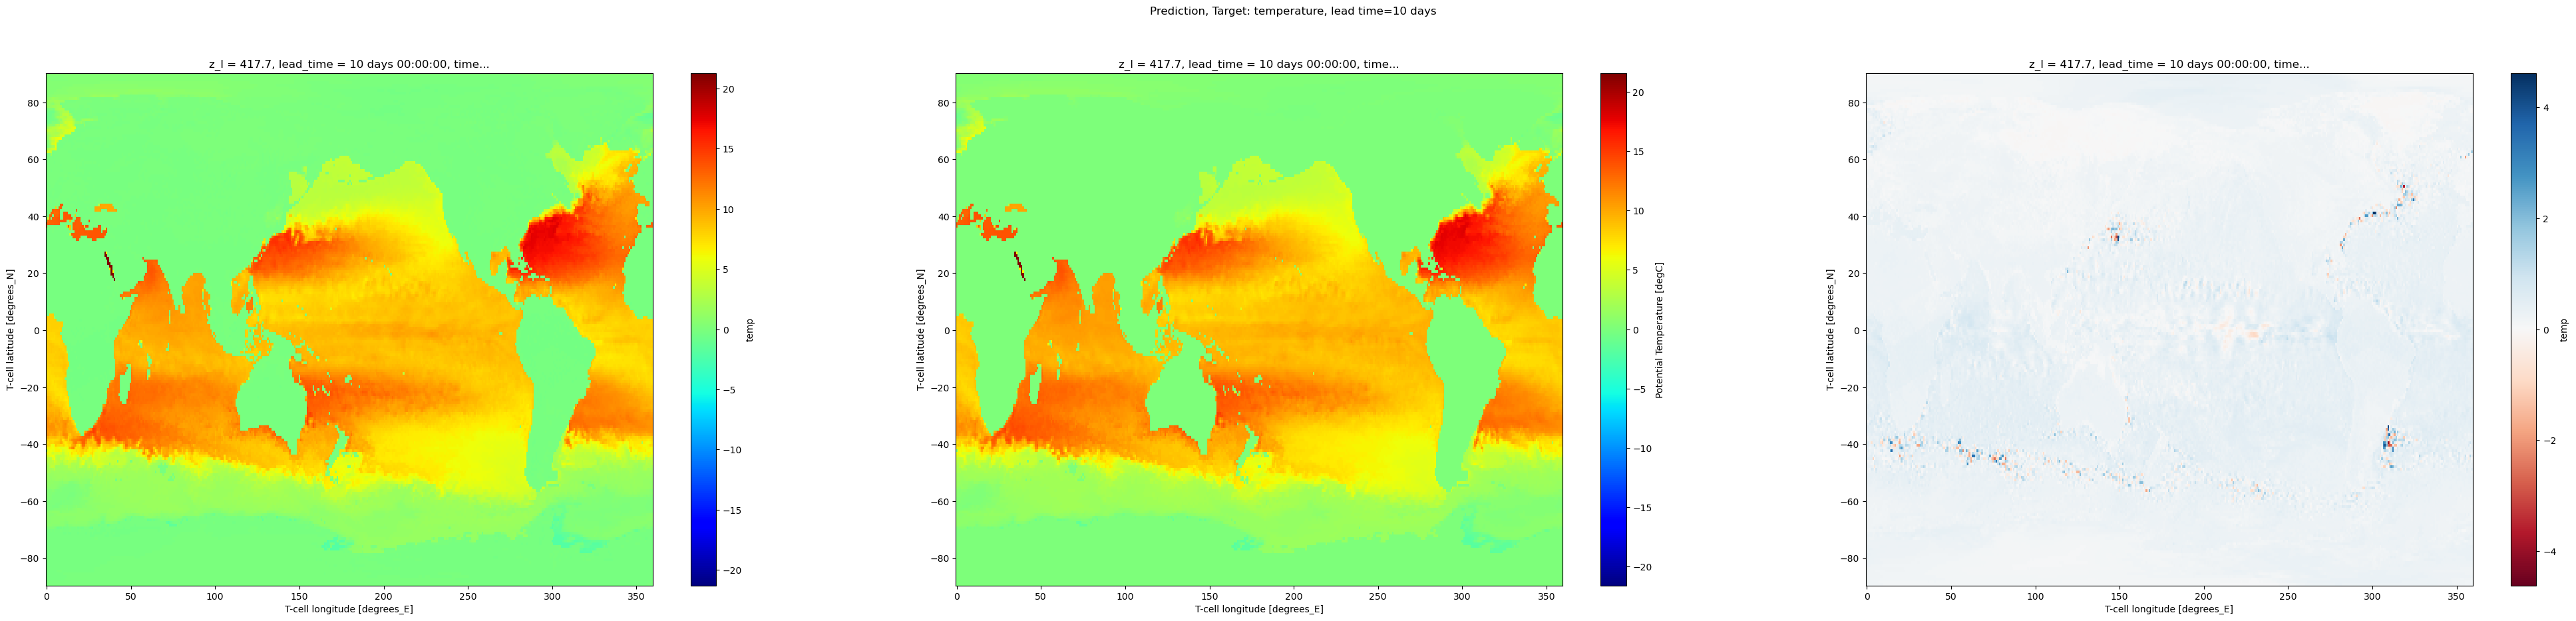

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(50,10))
predictions.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[0], cmap="jet")
targets.temp.isel(time=0, lead_time=-1, z_l=-1).plot(ax=ax[1], cmap="jet")
diff = targets.temp.isel(time=0, lead_time=-1, z_l=-1) - predictions.temp.isel(time=0, lead_time=-1, z_l=-1)
diff.plot(ax=ax[2], cmap='RdBu')
lead_time_days = predictions.lead_time[-1].values.astype('timedelta64[D]')
plt.suptitle(f'Prediction, Target: temperature, lead time={lead_time_days}')
plt.show()

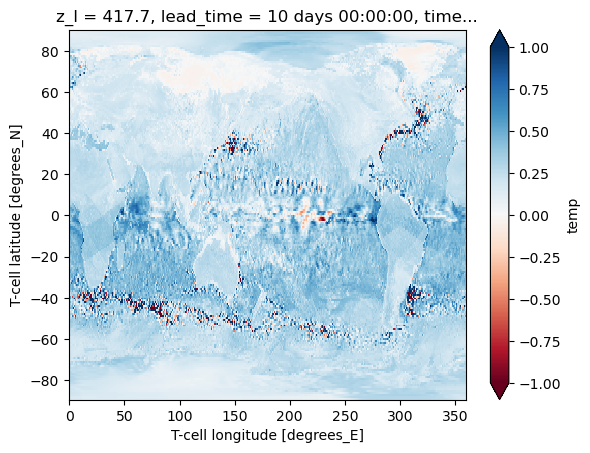

In [13]:
diff.plot(cmap='RdBu', vmin=-1, vmax=1)
plt.show()

In [31]:
print(predictions.lat[50].values)
print(predictions.lon[220].values)

42.979819538909815
206.25


In [35]:
predictions.soilm.isel(lat=50, lon=220, lead_time=-1).values

array([5.740899], dtype=float32)

In [34]:
targets.SSH.isel(lat=50, lon=220, lead_time=-1).values

array([0.08719323], dtype=float32)